In [1]:
%load_ext rpy2.ipython
%matplotlib inline

## Python API

Prophet follows the `sklearn` model API.  We create an instance of the `Prophet` class and then call its `fit` and `predict` methods.  

The input to Prophet is always a dataframe with two columns: `ds` and `y`.  The `ds` (datestamp) column must contain a date or datetime (either is fine). The `y` column must be numeric, and represents the measurement we wish to forecast.

As an example, let's look at a time series of daily page views for the Wikipedia page for [Peyton Manning](https://en.wikipedia.org/wiki/Peyton_Manning).  We scraped this data using the [Wikipediatrend](https://cran.r-project.org/web/packages/wikipediatrend/vignettes/using-wikipediatrend.html) package in R.  Peyton Manning provides a nice example because it illustrates some of Prophet's features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning's playoff and superbowl appearances).

First we'll import the data and log-transform the y variable.

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [3]:
df = pd.read_csv('../examples/example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


We fit the model by instantiated a new `Prophet` object.  Any settings to the forecasting procedure are passed into the constructor.  Then you call its `fit` method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [4]:
m = Prophet()
m.fit(df);

Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well. 

In [5]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


The `predict` method will assign each row in `future` a predicted value which it names `yhat`.  If you pass in historical dates, it will provide an in-sample fit. The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [6]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.205065,7.488507,8.887731
3266,2017-01-16,8.530088,7.862778,9.223688
3267,2017-01-17,8.317468,7.644606,9.021893
3268,2017-01-18,8.150081,7.462394,8.889095
3269,2017-01-19,8.162015,7.438503,8.877361


You can plot the forecast by calling the `Prophet.plot` method and passing in your forecast dataframe.

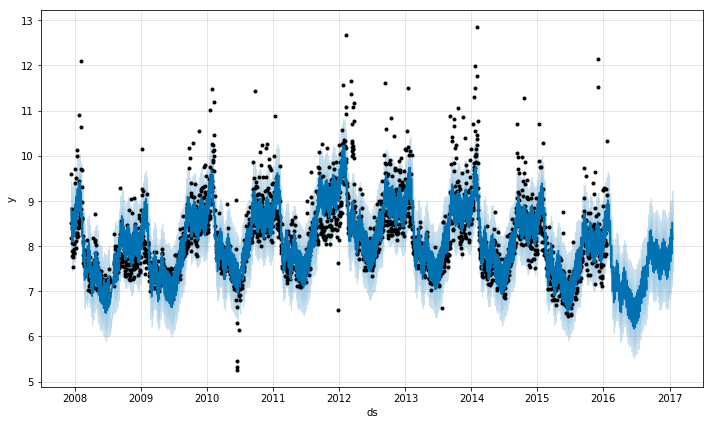

In [7]:
m.plot(forecast);

If you want to see the forecast components, you can use the `Prophet.plot_components` method.  By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series.  If you include holidays, you'll see those here, too.

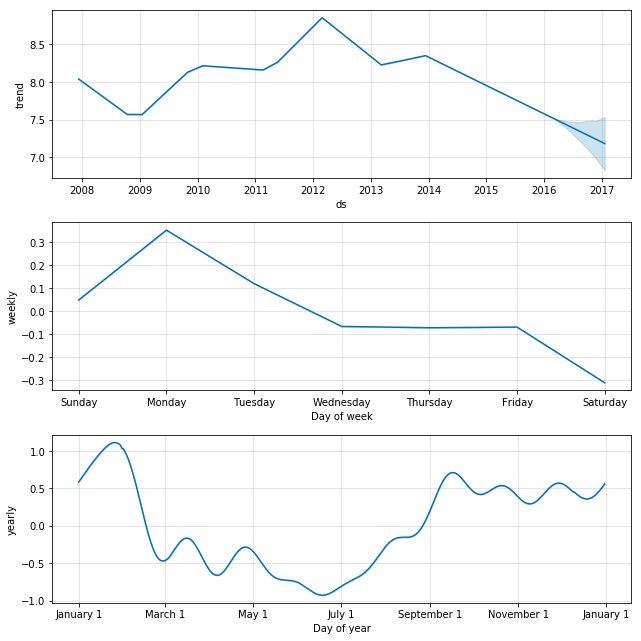

In [8]:
m.plot_components(forecast);

## R API

In R, we use the normal model fitting API.  We provide a `prophet` function that performs fitting and returns a model object.  You can then call `predict` and `plot` on this model object.

In [9]:
%%R
library(prophet)
library(dplyr)

/usr/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


First we read in the data and create the outcome variable. As in the Python API, this is a dataframe with columns `ds` and `y`, containing the date and numeric value respectively. As above, we use here the log number of views to Petyon Manning's Wikipedia page.

In [10]:
%%R
df <- read.csv('../examples/example_wp_peyton_manning.csv') %>%
  mutate(y = log(y))

We call the `prophet` function to fit the model.  The first argument is the historical dataframe.  Additional arguments control how Prophet fits the data and are described in later pages of this documentation.

In [11]:
%%R
m <- prophet(df)

STAN OPTIMIZATION COMMAND (LBFGS)
init = user
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 1236561514
initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Predictions are made on a dataframe with a column `ds` containing the dates for which predictions are to be made. The `make_future_dataframe` function takes the model object and a number of periods to forecast and produces a suitable dataframe. By default it will also include the historical dates so we can evaluate in-sample fit.

In [12]:
%%R
future <- make_future_dataframe(m, periods = 365)
tail(future)

             ds
3265 2017-01-14
3266 2017-01-15
3267 2017-01-16
3268 2017-01-17
3269 2017-01-18
3270 2017-01-19


As with most modeling procedures in R, we use the generic `predict` function to get our forecast. The `forecast` object is a dataframe with a column `yhat` containing the forecast. It has additional columns for uncertainty intervals and seasonal components.

In [13]:
%%R
forecast <- predict(m, future)
tail(forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')])

             ds     yhat yhat_lower yhat_upper
3265 2017-01-14 7.832396   7.140713   8.533132
3266 2017-01-15 8.214232   7.460897   8.918678
3267 2017-01-16 8.539239   7.788240   9.262142
3268 2017-01-17 8.326654   7.615613   9.003147
3269 2017-01-18 8.159337   7.382162   8.889958
3270 2017-01-19 8.171276   7.354854   8.922918


You can use the generic `plot` function to plot the forecast, by passing in the model and the forecast dataframe.

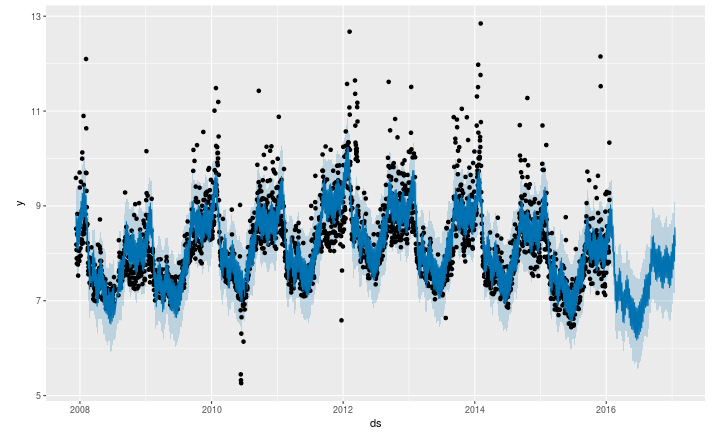

In [14]:
%%R -w 10 -h 6 -u in
plot(m, forecast)

You can use the `prophet_plot_components` function to see the forecast broken down into trend, weekly seasonality, and yearly seasonality.

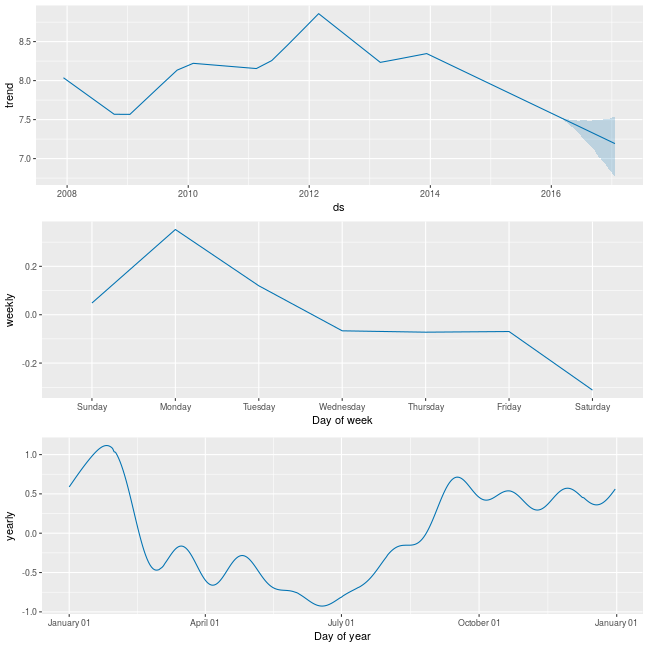

In [15]:
%%R -w 9 -h 9 -u in
prophet_plot_components(m, forecast)